We are going to predict once again if a passenger on the Titanic is going to survive or not using decision trees and random forests this time: 

1. Read your Titanic dataset as usual: Training set and Testing set Apply decision tree. 
2. Plot your decision tree and try to read the tree branches and conclude a prediction manually.
3. Change the decision tree parameters(change at least two parameters), 
4. Calculate the new accuracy and compare it with the previous results. 
5. Use random forest then change the number of estimators
6. Calculate the new accuracy and compare it with the previous result.

In [1]:
#Importing our dataset from csv file
import pandas as pd 
dataset=pd.read_csv("titanic-passengers.csv", sep=";")

#Preprocessing our data
def preprocess_data(new_data):
    new_data.Survived.replace({"Yes" : 1 , "No" : 0}, inplace = True) 
    
    new_data['Age'].fillna(new_data['Age'].mean(), inplace=True) 
     
    new_data.Sex.replace({'male': 1,'female':0}, inplace=True)
    new_data.rename(columns = { 'Sex' : 'isMale'}, inplace=True)
    
    new_data.Pclass.replace({ 1: 'First',2 : 'Second', 3 : 'Third'}, inplace=True)
    
    new_data.Fare = new_data.Fare.round(2)
    new_data['Family_Size'] = 1 + new_data.SibSp + new_data.Parch 
    
    new_data.Embarked = new_data.Embarked.fillna("S")
    
    new_data.drop(["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"], axis=1, inplace = True)
    new_data = pd.get_dummies(new_data)
    return new_data

data = preprocess_data(dataset)
data.head()

,Survived,isMale,Age,Fare,Family_Size,Pclass_First,Pclass_Second,Pclass_Third,Embarked_C,Embarked_Q,Embarked_S
0,0,1,28.0,13.00,1,0,1,0,0,0,1
1,0,1,25.0,7.65,1,0,0,1,0,0,1
2,0,1,20.0,7.85,1,0,0,1,0,0,1
3,0,0,29.0,21.08,5,0,0,1,0,0,1
4,0,1,31.0,52.00,2,1,0,0,0,0,1


In [2]:
#importing relevant libraries
from sklearn.model_selection import train_test_split
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [3]:
#features extraction
x = data.drop(["Survived"], axis=1)
y = data["Survived"]

#splitting data
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25,random_state=1)

In [4]:
#applying tree algorithm with standard parametre

clf_std = DecisionTreeClassifier()
clf_std.fit(x_train, y_train)   #fitting our model
y_pred = clf_std.predict(x_test)   # evaluating our model
print("score:{}".format(accuracy_score(y_test, y_pred)))

score:0.7713004484304933


In [5]:
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

import pydotplus
from IPython.display import IFrame
from io import StringIO

def decision_tree_pdf(model,feature_name,target_name):
    dot_data = StringIO()  
    tree.export_graphviz(model, out_file=dot_data,  
                         feature_names=feature_name,  
                         class_names=target_name,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_pdf("tree.pdf")
    

In [6]:
decision_tree_pdf(clf_std, x_train.columns,'Survived')
IFrame("tree.pdf", width=900, height=400)

In [7]:
from sklearn.model_selection import GridSearchCV

tree_para = {'criterion': ['gini','entropy'],
             'max_depth': [4,5,6,7,8,9,10],
             'min_samples_split' : [4,5,6,7,8,9,10],
             'random_state' : [1,3,5],
             'splitter' : ['best', 'random'] }

CV_clf = GridSearchCV(estimator=clf_std, param_grid=tree_para, cv= 5)
CV_clf.fit(x_train, y_train)
CV_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_split': 4,
 'random_state': 1,
 'splitter': 'random'}

In [8]:
#applying tree algorithm with best parametre
clf_best = DecisionTreeClassifier(criterion=CV_clf.best_params_['criterion'],
                                  max_depth=CV_clf.best_params_['max_depth'],
                                  min_samples_split=CV_clf.best_params_['min_samples_split'],
                                  random_state=CV_clf.best_params_['random_state'],
                                  splitter=CV_clf.best_params_['splitter']) 

clf_best.fit(x_train, y_train)   #fitting our model
y_pred = clf_best.predict(x_test)   # evaluating our model
print("score:{}".format(accuracy_score(y_test, y_pred)))

score:0.820627802690583


le score s'améliore avec des paramètre plus précis

In [9]:
from sklearn.ensemble import RandomForestClassifier

#applying random tree algorithm
rlf_std = RandomForestClassifier()
rlf_std.fit(x_train, y_train)   #fitting our model
y_pred = rlf_std.predict(x_test)   # evaluating our model
print("score:{}".format(accuracy_score(y_test, y_pred)))

score:0.7668161434977578


best score:0.8071748878923767 with 3 n_estimators


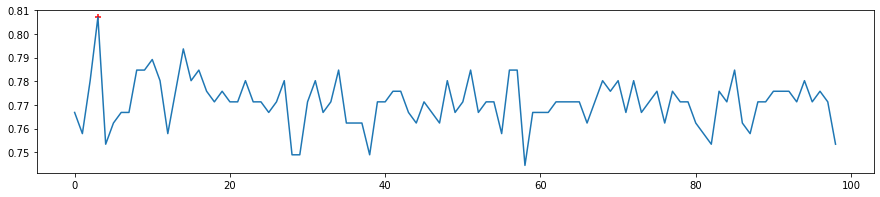

In [10]:
import matplotlib.pyplot as plt
scores = []

for n_estimators in range(1 , 100):
    #applying random tree algorithm
    rlf = RandomForestClassifier(n_estimators = n_estimators)
    rlf.fit(x_train, y_train)   #fitting our model
    y_pred=rlf.predict(x_test)   # evaluating our model
    scores.append(accuracy_score(y_test, y_pred))
    
x, y = max((val, idx) for (idx, val) in enumerate(scores))
figure = plt.subplots(figsize=(15, 3))
plt.plot(scores)
plt.scatter(y, x, marker='+', c = 'r')

print("best score:{} with {} n_estimators".format(x,y))
rlf_best_estimators = RandomForestClassifier(n_estimators = y)

In [13]:
for model in (clf_std, clf_best, rlf_std,  rlf_best_estimators):
    model.fit(x_train, y_train)   
    print (f'{round(model.score(x_test, y_test),4)} -- {model} ')

0.7668 -- DecisionTreeClassifier() 
0.8206 -- DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=4,
                       random_state=1, splitter='random') 
0.7758 -- RandomForestClassifier() 
0.7848 -- RandomForestClassifier(n_estimators=3) 


Le choix du **model apprentissage** et de son **paramétrage** est important,

 - ici le score est plus important pour le DecisionTreeClassifier avec un ajustement de plusieur paramétre 

reste a comprendre comment choisir le bon model et les meilleur paramétrage